# Alleviating Over-Smoothing in Graph Convolutional Networks Through Residual Weighted Shortest Path Neighborhood Aggregation

## Set up dependencies

In [8]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [9]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
!pip install torchviz
!pip install umap-learn

## Imports and Dataset Loading

In [10]:
# Imports
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv
from torch import Tensor
from torch_geometric.utils import to_dense_adj

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from matplotlib import gridspec


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Cora dataset
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=None
  )

print(dataset.data)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset
data = dataset.data
data = data.to(device)

val_mask = dataset.data.val_mask.to(device)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## Model definitions

### Define Vanilla GCN

In [4]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio

    # Define layers
    if n_layers == 0:
        self.fc = nn.Linear(input_dim, n_classes)
    else:
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hid_dim))
        for _ in range(n_layers - 1):
            self.convs.append(GCNConv(hid_dim, hid_dim))
        self.out_layer = nn.Linear(hid_dim, n_classes)

  def forward(self, X, A) -> Tensor:
        """
        Forward pass for the classification task.
        """
        if self.n_layers == 0:
            return self.fc(X)
        else:
            h = self.generate_node_embeddings(X, A)
            logits = self.out_layer(h)  # Final layer for classification
            return logits

  def generate_node_embeddings(self, X, A) -> Tensor:
      """
      Generate node embeddings for all layers.
      """
      if self.n_layers == 0:
          return self.fc(X)
      else:
          h = X
          for conv in self.convs:
              h = conv(h, A)  # Apply GCNConv
              h = F.relu(h)  # Apply ReLU
              h = F.dropout(h, p=self.dropout_ratio, training=self.training)  # Apply dropout
          return h

  def param_init(self):
      """
      Initialize parameters for the model.
      """
      if self.n_layers == 0:
        self.fc.reset_parameters()
      else:
        for conv in self.convs:
          conv.reset_parameters()
        self.out_layer.reset_parameters()

### Define GCN with Skip-Connections

In [5]:
class SkipGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(SkipGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
    """

    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio

    if n_layers == 0:
        self.fc = nn.Linear(input_dim, n_classes)
    else:
        self.convs = nn.ModuleList()

        # First layer: input_dim -> hid_dim
        self.convs.append(GCNConv(input_dim, hid_dim))

        # Subsequent layers: hid_dim * 2 -> hid_dim
        for _ in range(n_layers - 1):
            self.convs.append(GCNConv(hid_dim, hid_dim))

        # Final classification layer
        self.out_layer = nn.Linear(hid_dim, n_classes)

  def forward(self, X, A) -> torch.Tensor:
      """
      Forward pass for node classification.
      """
      if self.n_layers == 0:
          logits = self.fc(X)
      else:
          h = self.generate_node_embeddings(X, A)
          logits = self.out_layer(h)
      return logits

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
      """
      Generate node embeddings with skip connections.
      """
      if self.n_layers == 0:
            return self.fc(X)
      else:
          h = X  # Initial input features
          h_prev = None  # Placeholder for skip connections
          for i, conv in enumerate(self.convs):
              if h_prev is not None:  # Skip connection after the first layer
                  h = h + h_prev
              h = conv(h, A)  # Apply GCNConv
              h_prev = h  # Update skip connection
              h = F.relu(h)  # Apply ReLU
              h = F.dropout(h, p=self.dropout_ratio, training=self.training)  # Apply dropout
          return h

  def param_init(self):
      """
      Initialize parameters for the model.
      """
      if self.n_layers == 0:
        self.fc.reset_parameters()
      else:
        for conv in self.convs:
          conv.reset_parameters()
        self.out_layer.reset_parameters()

### Define GCN with Jumping Knowledge Connection

In [6]:
class JumpKnowGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(JumpKnowGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout ratio
    """
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio

    if n_layers == 0:
        self.fc = nn.Linear(input_dim, n_classes)
    else:
        self.convs = nn.ModuleList()

        # First layer: input_dim -> hid_dim
        self.convs.append(GCNConv(input_dim, hid_dim))

        # Additional layers: hid_dim -> hid_dim
        for _ in range(n_layers - 1):
            self.convs.append(GCNConv(hid_dim, hid_dim))

        self.out_layer = nn.Linear(hid_dim, n_classes)

  def forward(self, X, A) -> torch.Tensor:
        if self.n_layers == 0:
            logits = self.fc(X)
        else:
            h_jk = self.generate_node_embeddings(X, A)
            logits = self.out_layer(h_jk)
        return logits

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
      if self.n_layers == 0:
          return self.fc(X)
      else:
          h = X
          h_list = []
          for i, conv in enumerate(self.convs):
              h = conv(h, A)
              h = F.relu(h)
              h = F.dropout(h, p=self.dropout_ratio, training=self.training)
              if i > 0 or self.n_layers == 1:  # Skip the first layer unless n_layers == 1
                  h_list.append(h)

          if len(h_list) > 1:
              h_jk = torch.stack(h_list, dim=-1)  # Shape: [num_nodes, hid_dim, n_layers-1]
              h_jk, _ = torch.max(h_jk, dim=-1)
          else:
              h_jk = h_list[0]

          return h_jk

  def param_init(self):
      """
      Initialize parameters for the model.
      """
      if self.n_layers == 0:
        self.fc.reset_parameters()
      else:
        for conv in self.convs:
          conv.reset_parameters()
        self.out_layer.reset_parameters()

### Define Learnable Weight Shortest Path GCNN

#### Define the WSP Module

In [7]:
class WSP_GCNConv(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_hops: int = 2,
        use_residual: bool = False,
        learnable_residual_scale: bool = False,
        residual_scale_init: float = 0.2
    ):
        """
        Initializes the Weighted Shortest Path Aggregation module with optional residual connections.

        Args:
            input_dim (int): Input feature dimension.
            output_dim (int): Output feature dimension.
            n_hops (int, optional): Maximum number of hops to consider. Defaults to 2.
            use_residual (bool, optional): Whether to include residual connections. Defaults to False.
            learnable_residual_scale (bool, optional): Whether the residual scaling factor is learnable. Defaults to False.
            residual_scale_init (float, optional): Initial value for residual scaling. Used only if use_residual is True. Defaults to 0.2.
        """
        super(WSP_GCNConv, self).__init__()
        self.n_hops = n_hops
        self.use_residual = use_residual

        # Initialize raw weights (unconstrained)
        initial_weights = torch.linspace(-0.3, -1.0, steps=n_hops)
        self.raw_weights = nn.Parameter(initial_weights)

        # Linear transformation for aggregated features
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

        # Residual connection: align dimensions if necessary
        if self.use_residual:
            if input_dim != output_dim:
                self.residual = nn.Linear(input_dim, output_dim, bias=False)
            else:
                self.residual = nn.Identity()

            # Residual scaling factor
            if learnable_residual_scale:
                self.residual_scale = nn.Parameter(torch.tensor(residual_scale_init))
            else:
                self.register_buffer('residual_scale', torch.tensor(residual_scale_init))
        else:
            self.residual = None
            self.residual_scale = None

    def forward(self, h: Tensor, A_norm_d_list: list[Tensor]) -> Tensor:
        """
        Forward pass for weighted shortest path aggregation with optional residual connections.

        Args:
            h (Tensor): Node feature matrix [num_nodes, input_dim].
            A_norm_d_list (list[Tensor]): List of normalized adjacency matrices for each hop.

        Returns:
            Tensor: Aggregated node features [num_nodes, output_dim].
        """
        # Apply sigmoid to raw_weights to get normalized weights
        w = torch.sigmoid(self.raw_weights)  # Shape: [n_hops]

        # Initialize aggregation tensor
        agg = torch.zeros_like(h)

        # Iterate only over the required number of hops
        for i, A_norm_d in enumerate(A_norm_d_list[:self.n_hops], start=1):
            agg += w[i-1] * torch.mm(A_norm_d, h)

        # Apply linear transformation to aggregated features
        agg_transformed = self.linear(agg)

        if self.use_residual:
            residual = self.residual(h)
            out = agg_transformed + self.residual_scale * residual
        else:
            out = agg_transformed

        return out

    def reset_parameters(self):
        """
        Reset all learnable parameters in the module and possibly add random noise to raw_weights and residual_scale.
        """
        # Reset raw_weights to initial values
        self.raw_weights.data = torch.linspace(-0.3, -1.0, steps=self.n_hops).to(self.raw_weights.device)

        noise_std = 0.005 # Standard deviation of the noise
        self.raw_weights.data += torch.randn_like(self.raw_weights) * noise_std # Add small random noise to raw_weights

        # Reset linear transformation
        self.linear.reset_parameters()

        if self.use_residual:
            if isinstance(self.residual, nn.Linear):
                self.residual.reset_parameters()

            # Reset residual scaling
            if isinstance(self.residual_scale, nn.Parameter):
                nn.init.constant_(self.residual_scale, 0.2)
                # Add small random noise to residual_scale
                self.residual_scale.data += torch.randn_like(self.residual_scale) * noise_std
            else:
                self.residual_scale.data = torch.tensor(0.75).to(self.residual_scale.device)
                # Add small random noise to residual_scale
                self.residual_scale.data += torch.randn_like(self.residual_scale) * noise_std

#### Integrate WSP_GCNConv into a Model

In [8]:
class WSP_GCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hid_dim: int,
        n_classes: int,
        n_layers: int = 2,
        n_hops: int = 2,
        dropout_ratio: float = 0.3,
        use_residual: bool = False,
        learnable_residual_scale: bool = False
    ):
        super(WSP_GCN, self).__init__()
        """
        Args:
            input_dim (int): Input feature dimension.
            hid_dim (int): Hidden feature dimension.
            n_classes (int): Number of target classes.
            n_layers (int, optional): Number of layers. Defaults to 2.
            n_hops (int, optional): Maximum number of hops to consider. Defaults to 2.
            dropout_ratio (float, optional): Dropout ratio. Defaults to 0.3.
            use_residual (bool, optional): Whether to include residual connections. Defaults to False.
            learnable_residual_scale (bool, optional): Whether residual scaling is learnable. Defaults to False.
        """
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
        self.n_hops = n_hops
        self.use_residual = use_residual
        self.learnable_residual_scale = learnable_residual_scale

        # Define layers
        if n_layers == 0:
            self.fc = nn.Linear(input_dim, n_classes)
        else:
            self.convs = nn.ModuleList()
            # First layer: input_dim -> hid_dim
            self.convs.append(
                WSP_GCNConv(
                    input_dim,
                    hid_dim,
                    n_hops=n_hops,
                    use_residual=use_residual,
                    learnable_residual_scale=learnable_residual_scale
                )
            )
            # Subsequent layers: hid_dim -> hid_dim
            for _ in range(n_layers - 1):
                self.convs.append(
                    WSP_GCNConv(
                        hid_dim,
                        hid_dim,
                        n_hops=n_hops,
                        use_residual=use_residual,
                        learnable_residual_scale=learnable_residual_scale
                    )
                )
            # Final classification layer
            self.out_layer = nn.Linear(hid_dim, n_classes)

    def forward(self, X, A_norm_d_list: list[Tensor]) -> Tensor:
        """
        Forward pass for the classification task.

        Args:
            X (torch.Tensor): Node feature matrix [num_nodes, input_dim].
            A_norm_d_list (list[torch.Tensor]): List of normalized adjacency matrices for each hop.

        Returns:
            torch.Tensor: Logits for each node [num_nodes, n_classes].
        """
        if self.n_layers == 0:
            return self.fc(X)
        else:
            h = self.generate_node_embeddings(X, A_norm_d_list)
            logits = self.out_layer(h)  # Final layer for classification
            return logits

    def generate_node_embeddings(self, X, A_norm_d_list: list[Tensor]) -> Tensor:
        """
        Generate node embeddings by passing input through convolutional layers.

        Args:
            X (torch.Tensor): Node feature matrix [num_nodes, input_dim].
            A_norm_d_list (list[torch.Tensor]): List of normalized adjacency matrices for each hop.

        Returns:
            torch.Tensor: Node embeddings [num_nodes, hid_dim].
        """
        if self.n_layers == 0:
            return self.fc(X)
        else:
            h = X
            for conv in self.convs:
                h = conv(h, A_norm_d_list)  # Apply WSP_GCNConv
                h = F.relu(h)  # Apply ReLU activation
                h = F.dropout(h, p=self.dropout_ratio, training=self.training)  # Apply dropout
            return h

    def param_init(self):
        """
        Initialize parameters for the model.
        """
        if self.n_layers == 0:
            self.fc.reset_parameters()
        else:
            for conv in self.convs:
                conv.reset_parameters()
            self.out_layer.reset_parameters()

## Define Train and Test Functions

#### Setup Adjacency Matrix for WSP-GCN

In [9]:
adj_matrix = to_dense_adj(dataset.data.edge_index).squeeze(0).to(device)

In [10]:
def compute_normalized_adjacency(adj: Tensor, n_hops: int) -> list[Tensor]:
    """
    Computes normalized adjacency matrices for each hop up to n_hops.

    Args:
        adj (torch.Tensor): Adjacency matrix [num_nodes, num_nodes].
        n_hops (int): Maximum number of hops.

    Returns:
        list[torch.Tensor]: List of normalized adjacency matrices for each hop.
    """
    A_power_list = [adj.clone()]

    # Compute A^d for d = 2,...,n_hops
    for d in range(2, n_hops + 1):
        A_power = torch.mm(A_power_list[-1], adj)
        A_power_list.append(A_power.clone())

    exact_hop_adj = []
    for d in range(1, n_hops + 1):
        if d == 1:
            A_d = A_power_list[0].clone()
            A_d += torch.eye(A_d.size(0), device=A_d.device)  # Add self-loops for 1-hop
        else:
            A_d = (A_power_list[d-1] > 0).float()
            for i in range(1, d):
                A_d = A_d - A_power_list[i-1]
            A_d = (A_d > 0).float()
            A_d.fill_diagonal_(0)  # Remove self-loops for i >= 2
        exact_hop_adj.append(A_d)

    # Normalize each A_d
    A_norm_d_list = []
    for A_d in exact_hop_adj:
        degree_i = A_d.sum(dim=1)  # Degree vector
        degree_i = torch.where(degree_i > 0, degree_i, torch.ones_like(degree_i))  # Avoid division by zero
        D_i_inv_sqrt = torch.pow(degree_i, -0.5)
        D_i_inv_sqrt_matrix = torch.diag(D_i_inv_sqrt)
        A_norm_d = torch.mm(torch.mm(D_i_inv_sqrt_matrix, A_d), D_i_inv_sqrt_matrix)
        A_norm_d_list.append(A_norm_d)

    return A_norm_d_list

In [11]:
# Compute normalized adjacency matrices once
A_norm_d_list = compute_normalized_adjacency(adj_matrix, n_hops=10)  # Example with n_hops=4

#### Train Function

In [12]:
def train(params: typing.Dict, A_norm_d_list: list[Tensor]) -> torch.nn.Module:
    """
    This function trains a node classification model and returns the trained model object.
    It also logs validation accuracies, raw_weights, and residual_scale (for WSP_GCN) for visualization purposes.
    """
    global results  # Declare results as global to modify it within the function

    # Update parameters
    params["n_classes"] = dataset.num_classes  # Number of target classes
    params["input_dim"] = dataset.num_features  # Size of input features

    # Set a model
    if params['model_name'] == 'GCN':
        model = GCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'SkipGCN':
        model = SkipGCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'JumpKnowGCN':
        model = JumpKnowGCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'].startswith('WSP_GCN'):
        # Extract residual parameters
        use_residual = params.get("use_residual", False)
        learnable_residual_scale = params.get("learnable_residual_scale", False)
        num_hops = params.get("num_hops", 2)

        model = WSP_GCN(
            params["input_dim"],
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"],
            n_hops=num_hops,
            dropout_ratio=params.get("dropout_ratio", 0.3),
            use_residual=use_residual,
            learnable_residual_scale=learnable_residual_scale
        ).to(device)
    else:
        raise NotImplementedError(f"Model {params['model_name']} is not implemented.")

    # Initialize parameters
    model.param_init()

    # Define optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    loss_fn = torch.nn.CrossEntropyLoss()

    # Initialize storage for validation accuracies and weights
    val_accuracies = []
    weights_over_epochs = {}

    for epoch in range(params["epochs"]):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()

        # Forward pass
        if params['model_name'].startswith('WSP_GCN'):
            logits = model(data.x, A_norm_d_list)  # Use precomputed normalized adjacencies
        else:
            logits = model(data.x, data.edge_index)  # Use edge index
        loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Evaluate on the validation set
        if params['model_name'].startswith('WSP_GCN'):
            val_accuracy = evaluate(model, data, data.val_mask, A_norm_d_list)
        else:
            val_accuracy = evaluate(model, data, data.val_mask)
        val_accuracies.append(val_accuracy)

        # Track weights and residual scales for WSP_GCN
        if params['model_name'].startswith('WSP_GCN'):
            weights_over_epochs[epoch] = {}
            for layer_idx, layer in enumerate(model.convs):
                # Store raw_weights
                weights_over_epochs[epoch][layer_idx] = {
                    "raw_weights": layer.raw_weights.clone().detach().cpu().tolist()
                }
                # Store residual_scale if residual connections are used
                if layer.use_residual and layer.residual_scale is not None:
                    weights_over_epochs[epoch][layer_idx]["residual_scale"] = layer.residual_scale.clone().detach().cpu().item()
                else:
                    weights_over_epochs[epoch][layer_idx]["residual_scale"] = None  # Or omit this key if preferred

        # Print every 20 epochs
        if (epoch + 1) % 20 == 0:
            # if params['model_name'].startswith('WSP_GCN'):
            #     for idx, conv in enumerate(model.convs):
            #         print(f"Epoch {epoch+1}, Layer {idx+1} raw_weights: {conv.raw_weights.data}")
            #         if conv.use_residual:
            #             print(f"Epoch {epoch+1}, Layer {idx+1} residual_scale: {conv.residual_scale.data}")
            print(f"Epoch {epoch + 1}/{params['epochs']}, Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save validation accuracies and weights
    run = params.get("run", None)  # Get 'run' from params
    if run is not None:
        results[params["model_name"]][params["n_layers"]][run]["val_accuracies"] = val_accuracies
        if params['model_name'].startswith('WSP_GCN'):
            results[params["model_name"]][params["n_layers"]][run]["num_hops"] = params.get("num_hops", "N/A")  # Add num_hops
            results[params["model_name"]][params["n_layers"]][run]["weights_over_epochs"] = weights_over_epochs
    else:
        print("Warning: 'run' parameter not found in params. Validation accuracies and weights not saved.")

    return model

#### Evaluation Code

In [13]:
def evaluate(
    model,
    data,
    mask,
    A_norm_d_list: list[Tensor] = None
):
    """
    Evaluates the model on the given mask.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data (torch_geometric.data.Data): The graph data.
        mask (torch.Tensor): The mask indicating the nodes to evaluate.
        A_norm_d_list (Optional[list[Tensor]]): Precomputed normalized adjacency matrices for WSP_GCN.

    Returns:
        float: Accuracy percentage.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Use precomputed normalized adjacency if provided (WSP_GCN)
        if A_norm_d_list is not None:
            out = model(data.x, A_norm_d_list)  # Forward pass with precomputed adjacencies
        else:
            out = model(data.x, data.edge_index)  # Forward pass with edge index
        predictions = out.argmax(dim=1)  # Get predicted class for each node
        correct = (predictions[mask] == data.y[mask]).sum().item()  # Count correct predictions
        total = mask.sum().item()  # Total number of nodes in the mask
        accuracy = correct / total  # Calculate accuracy

    return accuracy * 100  # Return accuracy as a percentage

#### Testing Code

In [14]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 80,  # number of total training epochs
    "hid_dim": 64, # size of hidden features
    "n_layers": 10, # number of layers
    "model_name": "GCN"
}
training_params["n_layers"] = 10
model_1_layer = train(training_params, A_norm_d_list)

Epoch 20/80, Loss: 1.6383, Validation Accuracy: 32.6000
Epoch 40/80, Loss: 1.5265, Validation Accuracy: 23.2000
Epoch 60/80, Loss: 1.5043, Validation Accuracy: 26.2000
Epoch 80/80, Loss: 1.0622, Validation Accuracy: 30.0000


In [15]:
training_params["model_name"] = 'WSP_GCN'
training_params["n_layers"] = 10
training_params["num_hops"] = 1
training_params["use_residual"] = False
training_params["learnable_residual_scale"] = True
model_2_hops = train(training_params, A_norm_d_list)

Epoch 20/80, Loss: 1.9459, Validation Accuracy: 7.2000
Epoch 40/80, Loss: 1.9459, Validation Accuracy: 15.6000
Epoch 60/80, Loss: 1.9459, Validation Accuracy: 5.8000
Epoch 80/80, Loss: 1.9459, Validation Accuracy: 5.8000


In [16]:
training_params["model_name"] = 'WSP_GCN'
training_params["n_layers"] = 10
training_params["num_hops"] = 4
training_params["use_residual"] = True
training_params["learnable_residual_scale"] = False
model_2_hops = train(training_params, A_norm_d_list)

Epoch 20/80, Loss: 1.4911, Validation Accuracy: 39.8000
Epoch 40/80, Loss: 1.0781, Validation Accuracy: 65.2000
Epoch 60/80, Loss: 0.7600, Validation Accuracy: 66.4000
Epoch 80/80, Loss: 0.6564, Validation Accuracy: 69.6000


In [17]:
training_params["model_name"] = 'JumpKnowGCN'
training_params["n_layers"] = 10
training_params["num_hops"] = 4
model_2_hops = train(training_params, A_norm_d_list)

Epoch 20/80, Loss: 0.1153, Validation Accuracy: 81.6000
Epoch 40/80, Loss: 0.0142, Validation Accuracy: 73.8000
Epoch 60/80, Loss: 0.0033, Validation Accuracy: 75.6000
Epoch 80/80, Loss: 0.0032, Validation Accuracy: 76.8000


In [18]:
training_params["model_name"] = 'WSP_GCN'
training_params["n_layers"] = 1
training_params["num_hops"] = 3
model_2_hops = train(training_params, A_norm_d_list)

Epoch 20/80, Loss: 0.0705, Validation Accuracy: 75.6000
Epoch 40/80, Loss: 0.0081, Validation Accuracy: 74.4000
Epoch 60/80, Loss: 0.0093, Validation Accuracy: 73.8000
Epoch 80/80, Loss: 0.0106, Validation Accuracy: 74.4000


In [19]:
training_params["model_name"] = 'WSP_GCN'
training_params["n_layers"] = 1
training_params["num_hops"] = 4
model_2_hops = train(training_params, A_norm_d_list)

Epoch 20/80, Loss: 0.0503, Validation Accuracy: 77.4000
Epoch 40/80, Loss: 0.0090, Validation Accuracy: 76.4000
Epoch 60/80, Loss: 0.0071, Validation Accuracy: 75.8000
Epoch 80/80, Loss: 0.0113, Validation Accuracy: 75.0000


## Gather Data for Visualizations

#### Setup Params

In [20]:
# Define the list of models and their specific parameters
models = {
    "WSP_GCN_1hop_no_residual": {
        "num_hops": 1,
        "use_residual": False,
        "learnable_residual_scale": False
    },
    "WSP_GCN_2hop_no_residual": {
        "num_hops": 2,
        "use_residual": False,
        "learnable_residual_scale": False
    },
    "WSP_GCN_4hop_no_residual": {
        "num_hops": 4,
        "use_residual": False,
        "learnable_residual_scale": False
    },
    "WSP_GCN_2hop_residual_fixed": {
        "num_hops": 2,
        "use_residual": True,
        "learnable_residual_scale": False
    },
    "WSP_GCN_2hop_residual_learnable": {
        "num_hops": 2,
        "use_residual": True,
        "learnable_residual_scale": True
    },
    "WSP_GCN_4hop_residual_fixed": {
        "num_hops": 4,
        "use_residual": True,
        "learnable_residual_scale": False
    },
    "WSP_GCN_4hop_residual_learnable": {
        "num_hops": 4,
        "use_residual": True,
        "learnable_residual_scale": True
    },
    "GCN": {
        "num_hops": None  # Not applicable
    },
    "SkipGCN": {
        "num_hops": None  # Not applicable
    },
    "JumpKnowGCN": {
        "num_hops": None  # Not applicable
    }
}

# Define the number of layers to test
layer_counts = [1, 3, 8, 10]

# Number of runs per configuration
num_runs = 4

# Define other training parameters
base_training_params = {
    "lr": 0.005,  # Learning rate
    "weight_decay": 0.0005,  # Weight decay
    "epochs": 100,  # Number of training epochs
    "hid_dim": 64,  # Hidden dimension
    "dropout_ratio": 0.3  # Dropout ratio
}

# Set a seed for reproducibility
torch.manual_seed(123)

### Experiment Loop

In [21]:
# Global results dictionary to store all results
results = {}

# Iterate over each model configuration
for model_key, model_config in models.items():
    model_name = model_key
    num_hops = model_config["num_hops"]

    if model_key.startswith("WSP_GCN"):
      use_residual = model_config["use_residual"]
      learnable_residual_scale = model_config["learnable_residual_scale"]

    # Initialize a nested dictionary for this model
    results[model_name] = {}

    # Iterate over each layer count
    for n_layers in layer_counts:
        # Initialize a nested dictionary for this layer configuration
        results[model_name][n_layers] = {}

        # Define the parameters for this configuration
        training_params = base_training_params.copy()
        training_params.update({
            "model_name": model_name,
            "n_layers": n_layers,
            "use_residual": use_residual,
            "learnable_residual_scale": learnable_residual_scale
        })

        # Get the precomputed normalized adjacency list for the current number of hops
        training_params["num_hops"] = num_hops

        # Run multiple trials for statistical significance
        for run in range(1, num_runs + 1):
            print(f"\nRunning Model: {model_key}, Layers: {n_layers}, Run: {run}")

            # Initialize storage for this run
            results[model_name][n_layers][run] = {
                "val_accuracies": [],
                "final_test_accuracy": None,
                "val_node_embeddings": None,
                "weights_over_epochs": {}
            }

            # Add 'run' to training_params
            training_params["run"] = run

            # Train the model
            model = train(training_params, A_norm_d_list)

            # Validation accuracies and weights are collected during training
            if model_key.startswith("WSP_GCN"):
                test_accuracy = evaluate(model, dataset.data, dataset.data.test_mask, A_norm_d_list)
            else:
                test_accuracy = evaluate(model, dataset.data, dataset.data.test_mask)

            # Store final test accuracy
            results[model_name][n_layers][run]["final_test_accuracy"] = test_accuracy

            # Generate and store node embeddings
            model.eval()
            x = dataset.data.x.to(device)
            if model_key.startswith("WSP_GCN"):
                val_embeddings = model.generate_node_embeddings(x, A_norm_d_list)[val_mask]
            else:
                val_embeddings = model.generate_node_embeddings(x, dataset.data.edge_index)[val_mask]

            # Convert node_embeddings to a list for JSON serialization
            results[model_name][n_layers][run]["val_node_embeddings"] = val_embeddings.detach().cpu().numpy().tolist()

            print(f"Run {run} Test Accuracy: {test_accuracy:.2f}%")

# Save the results
with open("results.json", "w") as f:
    json.dump(results, f)


Running Model: WSP_GCN_1hop_no_residual, Layers: 1, Run: 1
Epoch 20/100, Loss: 0.7215, Validation Accuracy: 75.2000
Epoch 40/100, Loss: 0.0871, Validation Accuracy: 75.4000
Epoch 60/100, Loss: 0.0396, Validation Accuracy: 75.2000
Epoch 80/100, Loss: 0.0386, Validation Accuracy: 75.6000
Epoch 100/100, Loss: 0.0359, Validation Accuracy: 75.0000
Run 1 Test Accuracy: 77.50%

Running Model: WSP_GCN_1hop_no_residual, Layers: 1, Run: 2
Epoch 20/100, Loss: 0.7389, Validation Accuracy: 74.8000
Epoch 40/100, Loss: 0.0808, Validation Accuracy: 75.8000
Epoch 60/100, Loss: 0.0365, Validation Accuracy: 76.0000
Epoch 80/100, Loss: 0.0385, Validation Accuracy: 76.0000
Epoch 100/100, Loss: 0.0380, Validation Accuracy: 75.0000
Run 2 Test Accuracy: 76.90%

Running Model: WSP_GCN_1hop_no_residual, Layers: 1, Run: 3
Epoch 20/100, Loss: 0.7392, Validation Accuracy: 72.0000
Epoch 40/100, Loss: 0.0849, Validation Accuracy: 76.0000
Epoch 60/100, Loss: 0.0396, Validation Accuracy: 76.6000
Epoch 80/100, Loss: 0

## Visualization

In [11]:
# Load the results from the JSON file
with open("results.json", "r") as f:
    results = json.load(f)

### Visualization #1: Final Test Accuracies with Standard Deviation

In [23]:
# Initialize a list to store the summary data
summary_data = []

# Iterate over each model in the results
for model_name, layers_dict in results.items():
    for n_layers, runs_dict in layers_dict.items():
        # Initialize a list to store test accuracies for all runs
        test_accuracies = []
        num_hops = None

        for run_num, run_data in runs_dict.items():
            test_acc = run_data.get("final_test_accuracy", None)
            if test_acc is not None:
                test_accuracies.append(test_acc)

            # Extract number of hops for WSP_GCN
            if model_name.startswith("WSP_GCN") and "num_hops" in run_data:
                num_hops = run_data.get("num_hops", None)

        # Compute mean and standard deviation if there are multiple runs
        if len(test_accuracies) > 0:
            mean_acc = np.mean(test_accuracies)
            std_acc = np.std(test_accuracies)
        else:
            mean_acc = None
            std_acc = None

        # Append the data to the summary list
        summary_data.append({
            "Model": model_name,
            "Number_of_Layers": n_layers,
            "Num_Hops": num_hops if model_name == "WSP_GCN" else "N/A",
            "Mean_Test_Accuracy (%)": round(mean_acc, 2) if mean_acc is not None else "N/A",
            "Std_Dev_Test_Accuracy (%)": round(std_acc, 2) if std_acc is not None else "N/A"
        })

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Sort the DataFrame for better readability
summary_df = summary_df.sort_values(by=["Model", "Number_of_Layers"])

# Print line-by-line results
print("\nLine-by-line summary of final accuracies and standard deviations:")
for index, row in summary_df.iterrows():
    print(
        f"Model: {row['Model']}, "
        f"Number of Layers: {row['Number_of_Layers']}, "
        f"Num Hops: {row['Num_Hops']}, "
        f"Mean Test Accuracy: {row['Mean_Test_Accuracy (%)']}%, "
        f"Std Dev: {row['Std_Dev_Test_Accuracy (%)']}%"
    )


Line-by-line summary of final accuracies and standard deviations:
Model: GCN, Number of Layers: 1, Num Hops: N/A, Mean Test Accuracy: 77.18%, Std Dev: 0.38%
Model: GCN, Number of Layers: 10, Num Hops: N/A, Mean Test Accuracy: 47.52%, Std Dev: 10.96%
Model: GCN, Number of Layers: 3, Num Hops: N/A, Mean Test Accuracy: 79.45%, Std Dev: 1.6%
Model: GCN, Number of Layers: 8, Num Hops: N/A, Mean Test Accuracy: 66.77%, Std Dev: 3.94%
Model: JumpKnowGCN, Number of Layers: 1, Num Hops: N/A, Mean Test Accuracy: 77.85%, Std Dev: 1.05%
Model: JumpKnowGCN, Number of Layers: 10, Num Hops: N/A, Mean Test Accuracy: 78.3%, Std Dev: 1.13%
Model: JumpKnowGCN, Number of Layers: 3, Num Hops: N/A, Mean Test Accuracy: 79.73%, Std Dev: 0.54%
Model: JumpKnowGCN, Number of Layers: 8, Num Hops: N/A, Mean Test Accuracy: 79.0%, Std Dev: 0.97%
Model: SkipGCN, Number of Layers: 1, Num Hops: N/A, Mean Test Accuracy: 77.0%, Std Dev: 0.47%
Model: SkipGCN, Number of Layers: 10, Num Hops: N/A, Mean Test Accuracy: 75.82%

### Visualization #2: Validation over Epochs

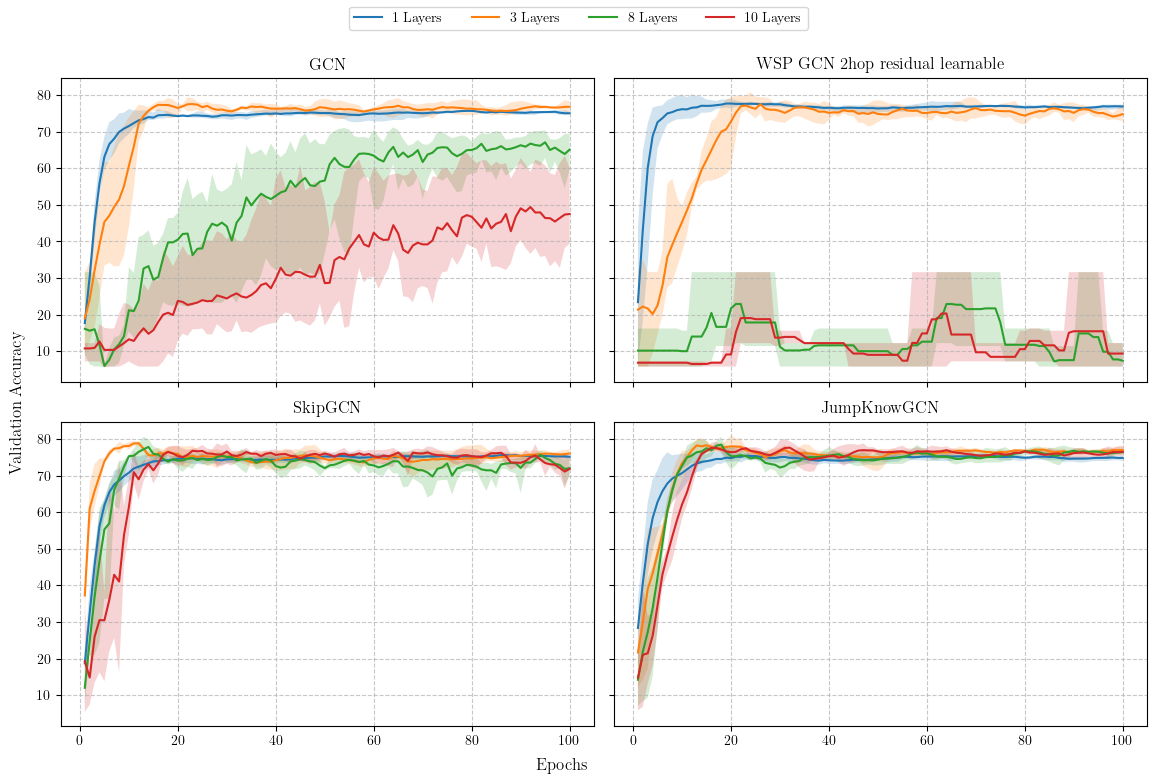

In [19]:
# Models and configurations
models_to_plot = ["GCN", "WSP_GCN_2hop_residual_learnable", "SkipGCN", "JumpKnowGCN"]
layers_to_plot = [1, 3, 8, 10]  # Layers to include in the visualization

# Setup LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

# To store handles and labels for the legend
handles = []
labels = []

# Iterate over models
for idx, model_name in enumerate(models_to_plot):
    ax = axs[idx]
    for n_layers in layers_to_plot:
        # Collect validation accuracy data for the specific model and layer
        val_accuracies = []
        for run_data in results.get(model_name, {}).get(str(n_layers), {}).values():
            val_acc = run_data.get("val_accuracies", [])
            if val_acc:
                val_accuracies.append(val_acc)

        if val_accuracies:
            val_accuracies = np.array(val_accuracies)
            mean_acc = val_accuracies.mean(axis=0)
            min_acc = val_accuracies.min(axis=0)
            max_acc = val_accuracies.max(axis=0)

            # Plot mean line and shaded area
            epochs = np.arange(1, len(mean_acc) + 1)
            line, = ax.plot(epochs, mean_acc, label=f"{n_layers} Layers")
            ax.fill_between(epochs, min_acc, max_acc, alpha=0.2)

            # Collect handles and labels only once for the legend
            if idx == 0:
                handles.append(line)
                labels.append(f"{n_layers} Layers")

    ax.set_title(model_name.replace("_", " "), fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)

# Add a single shared legend
fig.legend(handles, labels, loc='upper center', ncol=len(layers_to_plot), fontsize=10)

# Add shared x and y labels
fig.text(0.5, 0.04, "Epochs", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Validation Accuracy", va='center', rotation='vertical', fontsize=12)

# Adjust layout to make space for the shared labels and legend
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.savefig("validation_accuracy_plots.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Visualization #3: UMAP Visualizations

In [25]:
import umap

# Define the model and layers to plot
model_name = "WSP_GCN_2hop_residual_learnable"
layers_to_plot = [1, 3, 8, 10]

# Initialize a dictionary to store the DataFrames for each layer
feature_dict = {}

# Iterate over the specified layers
for n_layers in layers_to_plot:
    # Access the runs for this model and layer
    runs_dict = results.get(model_name, {}).get(str(n_layers), {})
    if not runs_dict:
        print(f"No data found for {model_name} with {n_layers} layers.")
        continue

    # Select the first run for visualization
    first_run_key = next(iter(runs_dict.keys()), None)
    if first_run_key is None:
        print(f"No runs found for {model_name} with {n_layers} layers.")
        continue

    first_run = runs_dict[first_run_key]

    val_embeddings = np.array(first_run.get("val_node_embeddings", []))

    if val_embeddings.size == 0:
        print(f"No embeddings found for {model_name} with {n_layers} layers in run {first_run_key}.")
        continue

    # Access labels directly from the dataset
    val_labels = dataset.data.y[val_mask].cpu().numpy()

    # Check if the number of embeddings matches the number of labels
    if len(val_embeddings) != len(val_labels):
        print(f"Mismatch between embeddings and labels for {model_name} with {n_layers} layers in run {first_run_key}.")
        continue

    # Perform UMAP dimensionality reduction
    try:
        reducer = umap.UMAP(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(val_embeddings)
    except Exception as e:
        print(f"t-SNE failed for {model_name} with {n_layers} layers in run {first_run_key}: {e}")
        continue

    # Create a DataFrame for visualization
    df = pd.DataFrame(reduced_embeddings, columns=["Dimension 1", "Dimension 2"])
    df["labels"] = val_labels

    # Add to the feature dictionary
    feature_dict[f"{n_layers}_layer"] = df

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data`

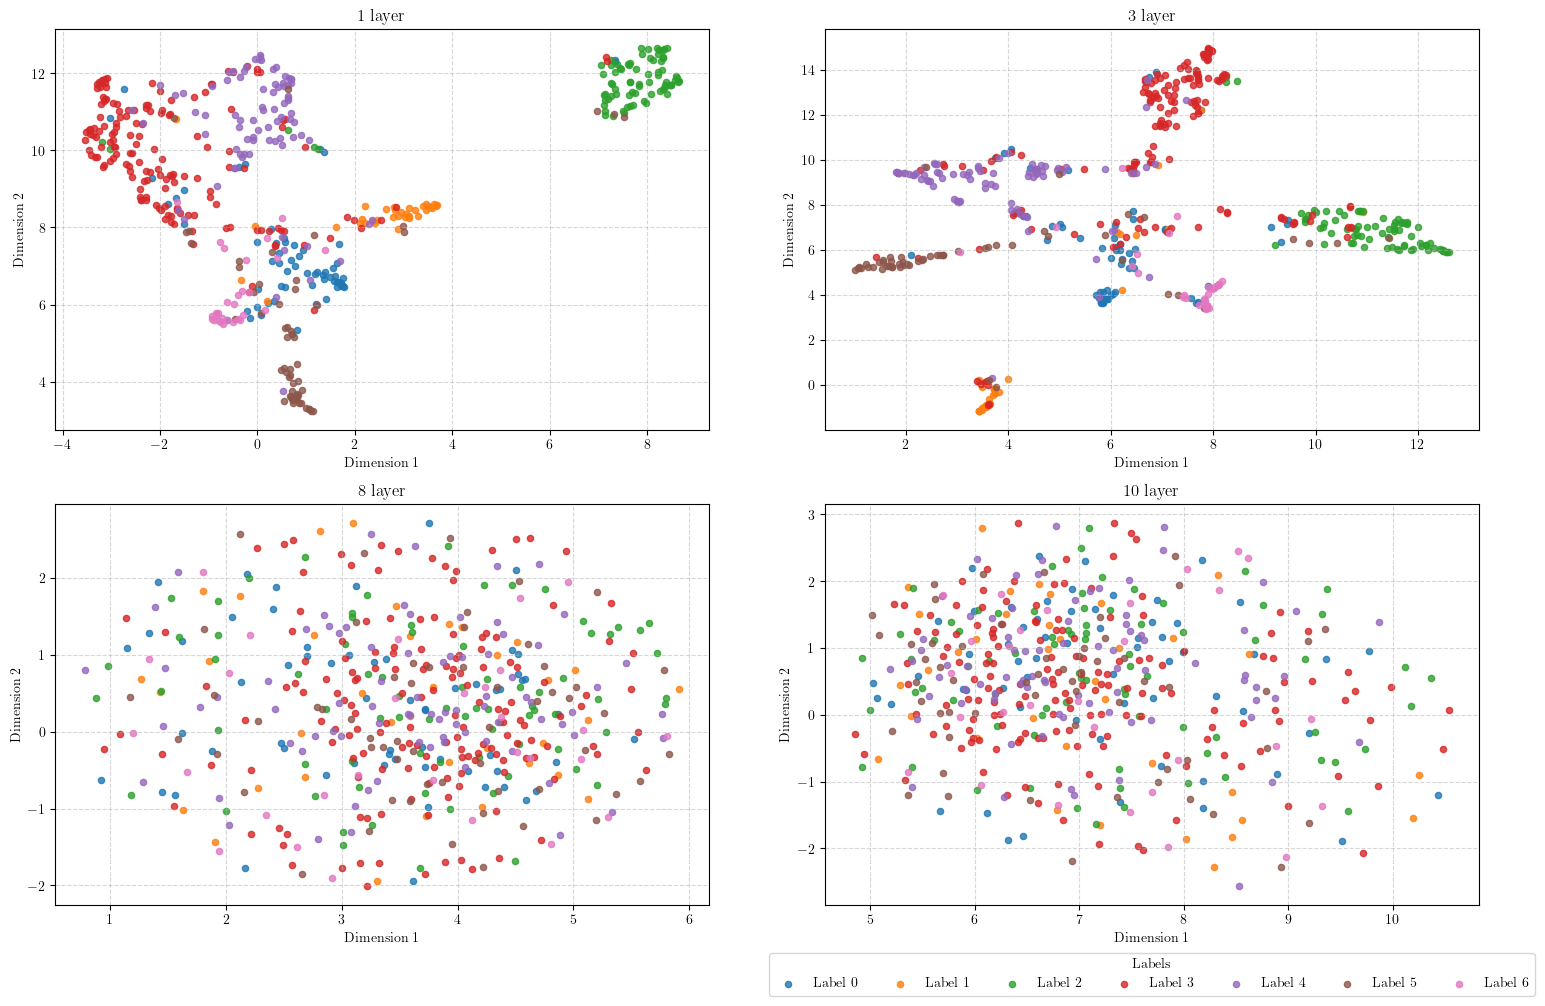

In [26]:
# Define the visualization function
def visualise(feature_dict: dict) -> None:
    plt.figure(figsize=(16, 12))

    # Collect handles and labels for the shared legend
    handles = []
    labels = []

    for idx, (key, df) in enumerate(feature_dict.items(), 1):
        ax = plt.subplot(2, 2, idx)  # Create a 2x2 grid for visualization
        unique_labels = sorted(df["labels"].unique())  # Sort the labels in ascending order

        # Plot each class and collect handles/labels
        for label in unique_labels:
            label_data = df[df["labels"] == label]
            scatter = ax.scatter(
                label_data["Dimension 1"],
                label_data["Dimension 2"],
                label=f"Label {label}",
                alpha=0.8,
                s=20  # Adjust marker size as needed
            )
            if idx == 1:  # Collect handles and labels only once
                handles.append(scatter)
                labels.append(f"Label {label}")

        ax.set_title(f"{key.replace('_', ' ').capitalize()}", fontsize=12)
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.grid(True, linestyle="--", alpha=0.5)

    # Create a single shared legend
    plt.legend(
        handles,
        labels,
        title="Labels",
        loc="center",
        bbox_to_anchor=(0.5, -0.175),  # Center below the plots
        ncol=len(labels),
        fontsize=10
    )

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    plt.savefig("umap_visualizations_2hop.pdf", format="pdf", bbox_inches="tight")

    plt.show()

# Call the visualization function
visualise(feature_dict)

#### Plot visualizations for 1, 2 and 4-hop distances

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


No data found for WSP_GCN_1hop with 1 layers.
No data found for WSP_GCN_1hop with 3 layers.
No data found for WSP_GCN_1hop with 8 layers.
No data found for WSP_GCN_1hop with 10 layers.
No data found for WSP_GCN_2hop with 1 layers.
No data found for WSP_GCN_2hop with 3 layers.
No data found for WSP_GCN_2hop with 8 layers.
No data found for WSP_GCN_2hop with 10 layers.
No data found for WSP_GCN_4hop with 1 layers.
No data found for WSP_GCN_4hop with 3 layers.
No data found for WSP_GCN_4hop with 8 layers.
No data found for WSP_GCN_4hop with 10 layers.


<ipython-input-27-101bbd474884>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


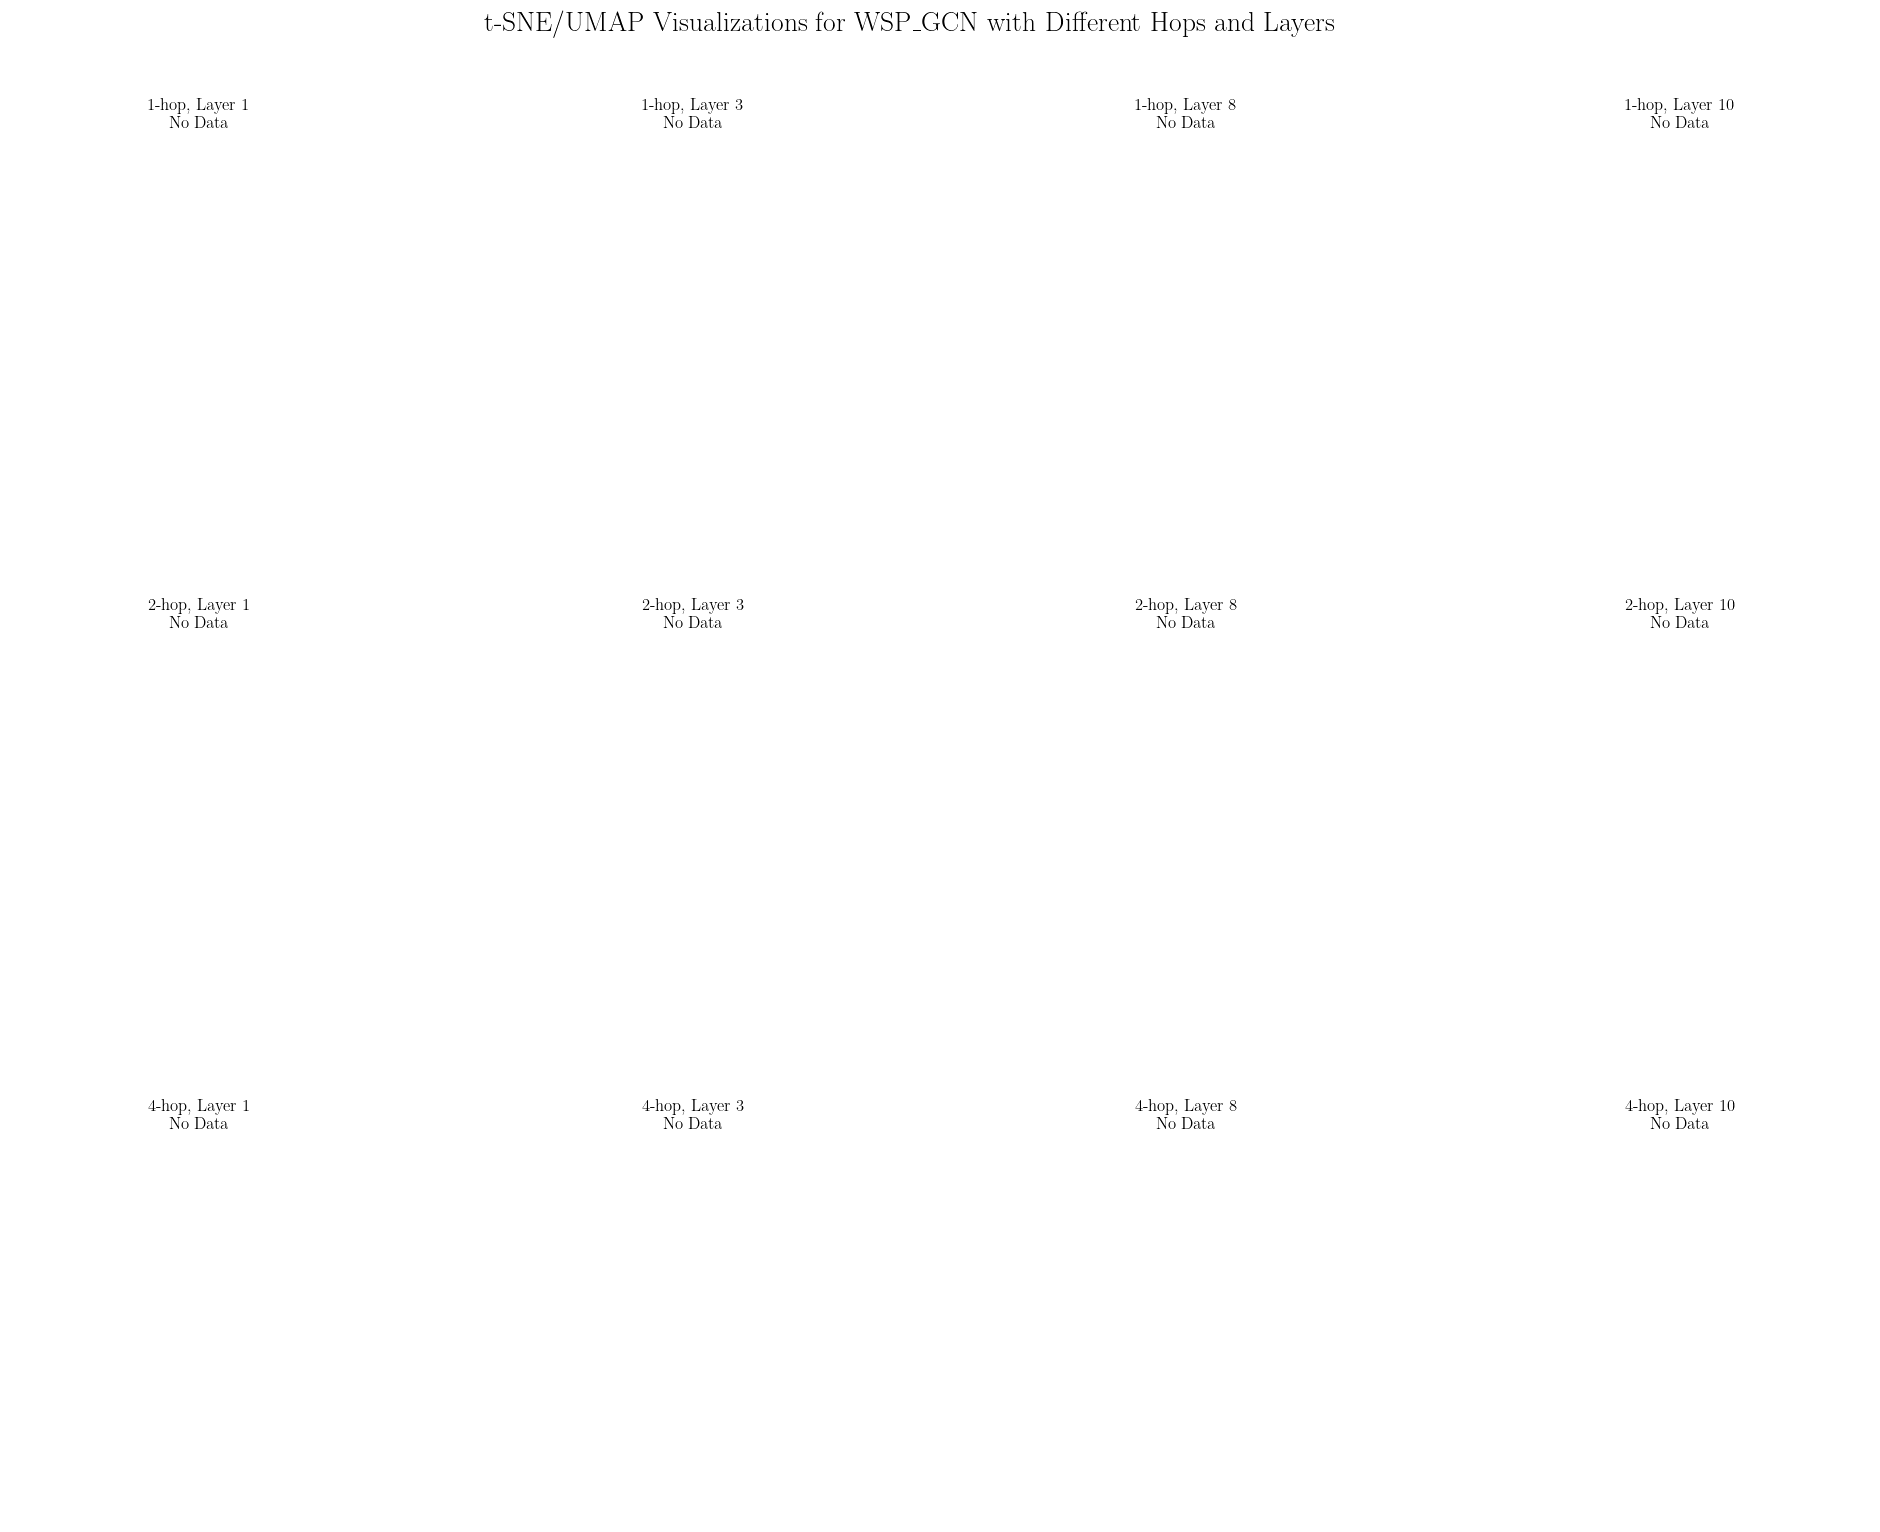

In [27]:
# Path to your results.json file
results_path = "results.json"

# Define the model name and hops
model_name = "WSP_GCN"
hops = [1, 2, 4]
layers_to_plot = [1, 3, 8, 10]

# Define colors for labels
unique_labels = dataset.data.y[val_mask].unique().cpu().numpy()
num_classes = len(unique_labels)
cmap = plt.get_cmap('tab10')
label_colors = {label: cmap(i % 10) for i, label in enumerate(unique_labels)}

# Define figure layout
fig = plt.figure(figsize=(24, 18))
from matplotlib import gridspec  # Import gridspec explicitly
outer_grid = gridspec.GridSpec(len(hops), 1, wspace=0.2, hspace=0.3)



for row, hop in enumerate(hops):
    # Create a GridSpec for each hop
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, len(layers_to_plot), subplot_spec=outer_grid[row], wspace=0.3, hspace=0.3)

    for col, layer in enumerate(layers_to_plot):
        ax = plt.Subplot(fig, inner_grid[col])
        fig.add_subplot(ax)

        # Construct the key for the current hop
        hop_key = f"{hop}hop" if hop !=1 else "1hop"
        model_key = f"{model_name}_{hop_key}"

        # Access the runs for this model, layer
        runs_dict = results.get(model_key, {}).get(layer, {})
        if not runs_dict:
            print(f"No data found for {model_key} with {layer} layers.")
            ax.axis('off')
            ax.set_title(f"{hop}-hop, Layer {layer}\nNo Data", fontsize=12)
            continue

        # Select the first run for visualization
        first_run_key = next(iter(runs_dict.keys()), None)
        if first_run_key is None:
            print(f"No runs found for {model_key} with {layer} layers.")
            ax.axis('off')
            ax.set_title(f"{hop}-hop, Layer {layer}\nNo Runs", fontsize=12)
            continue

        first_run = runs_dict[first_run_key]
        val_embeddings = np.array(first_run.get("val_node_embeddings", []))

        if val_embeddings.size == 0:
            print(f"No embeddings found for {model_key} with {layer} layers in run {first_run_key}.")
            ax.axis('off')
            ax.set_title(f"{hop}-hop, Layer {layer}\nNo Embeddings", fontsize=12)
            continue

        # Access labels directly from the dataset
        val_labels = dataset.data.y[val_mask].cpu().numpy()

        # Check if the number of embeddings matches the number of labels
        if len(val_embeddings) != len(val_labels):
            print(f"Mismatch between embeddings and labels for {model_key} with {layer} layers in run {first_run_key}.")
            ax.axis('off')
            ax.set_title(f"{hop}-hop, Layer {layer}\nMismatch", fontsize=12)
            continue

        # Perform UMAP dimensionality reduction
        try:
            reducer = umap.UMAP(n_components=2, random_state=42)
            reduced_embeddings = reducer.fit_transform(val_embeddings)
        except Exception as e:
            print(f"UMAP failed for {model_key} with {layer} layers in run {first_run_key}: {e}")
            ax.axis('off')
            ax.set_title(f"{hop}-hop, Layer {layer}\nUMAP Failed", fontsize=12)
            continue

        # Create a DataFrame for visualization
        df = pd.DataFrame(reduced_embeddings, columns=["Dimension 1", "Dimension 2"])
        df["labels"] = val_labels

        # Plot each class separately
        for label in unique_labels:
            label_data = df[df["labels"] == label]
            ax.scatter(
                label_data["Dimension 1"],
                label_data["Dimension 2"],
                label=f"Class {label}",
                alpha=0.7,
                s=30,
                color=label_colors[label],
                edgecolors='w',
                linewidth=0.5
            )

        ax.set_title(f"Layer {layer}", fontsize=12)
        ax.set_xlabel("Dimension 1", fontsize=10)
        ax.set_ylabel("Dimension 2", fontsize=10)
        ax.legend(loc='best', fontsize=8, markerscale=1.5)
        ax.grid(True, linestyle='--', alpha=0.3)

# Add a super title
fig.suptitle(f"t-SNE/UMAP Visualizations for {model_name} with Different Hops and Layers", fontsize=20, y=0.95)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()

### Visualization #4: Silhouette Score and Davies-Bouldin Index for different models and layer depths

In [28]:
# Initialize a list to store the summary data
summary_data = []

# Iterate over each model in the results
for model_key, layers_dict in results.items():
    for n_layers, runs_dict in layers_dict.items():
        # Select the first run for each model-layer configuration
        first_run_key = next(iter(runs_dict.keys()), None)
        if first_run_key is None:
            print(f"No runs found for {model_key} with {n_layers} layers.")
            continue

        run_data = runs_dict[first_run_key]

        # Extract node embeddings
        val_embeddings = np.array(run_data.get("val_node_embeddings", []))
        if val_embeddings.size == 0:
            print(f"No embeddings found for {model_key} with {n_layers} layers in run {first_run_key}.")
            continue

        # Access labels directly from the dataset
        try:
            val_labels = dataset.data.y[val_mask].cpu().numpy()
        except NameError:
            raise NameError("Ensure that 'dataset' and 'val_mask' are defined in your environment.")

        # Check if the number of embeddings matches the number of labels
        if len(val_embeddings) != len(val_labels):
            print(f"Mismatch between embeddings and labels for {model_key} with {n_layers} layers in run {first_run_key}.")
            continue

        # Compute Silhouette Score and Davies-Bouldin Index
        try:
            silhouette = silhouette_score(val_embeddings, val_labels)
            db_index = davies_bouldin_score(val_embeddings, val_labels)
        except Exception as e:
            print(f"Error computing metrics for {model_key} with {n_layers} layers in run {first_run_key}: {e}")
            silhouette = None
            db_index = None

        # Extract Num_Hops from the model_key if applicable
        if "hop" in model_key:
            try:
                num_hops_str = ''.join(filter(str.isdigit, model_key.split('_')[-1]))
                num_hops = int(num_hops_str) if num_hops_str.isdigit() else "N/A"
            except Exception as e:
                print(f"Error extracting number of hops from model_key '{model_key}': {e}")
                num_hops = "N/A"
        else:
            num_hops = "N/A"

        # Append the metrics to the summary_data list
        summary_data.append({
            "Model": model_key,
            "Number_of_Layers": n_layers,
            "Num_Hops": num_hops,
            "Silhouette_Score": round(silhouette, 4) if silhouette is not None else "N/A",
            "Davies-Bouldin_Index": round(db_index, 4) if db_index is not None else "N/A"
        })

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Sort the DataFrame for better readability
summary_df = summary_df.sort_values(by=["Model", "Number_of_Layers"]).reset_index(drop=True)

# Display the DataFrame
# print(summary_df)

print("\nLine-by-line summary of Silhouette Score and Davies-Bouldin Index:")
for index, row in summary_df.iterrows():
    print(
        f"Model: {row['Model']}, "
        f"Number of Layers: {row['Number_of_Layers']}, "
        f"Num Hops: {row['Num_Hops']}, "
        f"Silhouette Score: {row['Silhouette_Score']}, "
        f"Davies-Bouldin Index: {row['Davies-Bouldin_Index']}"
    )

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d


Line-by-line summary of Silhouette Score and Davies-Bouldin Index:
Model: GCN, Number of Layers: 1, Num Hops: N/A, Silhouette Score: 0.1494, Davies-Bouldin Index: 1.6367
Model: GCN, Number of Layers: 10, Num Hops: N/A, Silhouette Score: 0.029, Davies-Bouldin Index: 3.1104
Model: GCN, Number of Layers: 3, Num Hops: N/A, Silhouette Score: 0.2324, Davies-Bouldin Index: 1.3262
Model: GCN, Number of Layers: 8, Num Hops: N/A, Silhouette Score: 0.129, Davies-Bouldin Index: 1.5411
Model: JumpKnowGCN, Number of Layers: 1, Num Hops: N/A, Silhouette Score: 0.1451, Davies-Bouldin Index: 1.6646
Model: JumpKnowGCN, Number of Layers: 10, Num Hops: N/A, Silhouette Score: 0.2158, Davies-Bouldin Index: 1.4037
Model: JumpKnowGCN, Number of Layers: 3, Num Hops: N/A, Silhouette Score: 0.2242, Davies-Bouldin Index: 1.3887
Model: JumpKnowGCN, Number of Layers: 8, Num Hops: N/A, Silhouette Score: 0.2204, Davies-Bouldin Index: 1.4004
Model: SkipGCN, Number of Layers: 1, Num Hops: N/A, Silhouette Score: 0.1498

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

### Visualization #5: Distribution of Final Weights

In [29]:
# Define the model configurations for 4-hop with residual
model_names = {
    "WSP_GCN_4hop_residual_learnable": 4
}

# Define the number of layers and selected layers for 4-hop
n_layers_target = 10
selected_layers = [1, 3, 8, 10]

# Initialize dictionaries to store raw weights and residual scales for 4-hop
weights_4hop_raw = {layer: {hop: [] for hop in range(1,5)} for layer in selected_layers}
weights_4hop_residual = {layer: [] for layer in selected_layers}

# Iterate over each model (only 4-hop)
for model_key, num_hops in model_names.items():
    if model_key not in results:
        print(f"Model {model_key} not found in results.")
        continue
    for n_layers, runs_dict in results[model_key].items():
        if int(n_layers) != n_layers_target:
            continue  # Only consider the target number of layers (10)
        for run_num, run_data in runs_dict.items():
            weights_over_epochs = run_data.get("weights_over_epochs", {})
            if not weights_over_epochs:
                print(f"No weights_over_epochs found for {model_key}, layer {n_layers}, run {run_num}.")
                continue
            # Get the last epoch
            last_epoch = max(int(epoch) for epoch in weights_over_epochs.keys())
            final_weights = weights_over_epochs[str(last_epoch)]  # dict: layer_idx: {"raw_weights": [...], "residual_scale": ...}
            print(f"Run {run_num}, Final Epoch {last_epoch}, Weights: {final_weights}")
            # Iterate over layers
            for layer_idx_str, layer_weights in final_weights.items():
                layer_idx = int(layer_idx_str) + 1  # Convert string index to integer and make it 1-based
                if layer_idx not in selected_layers:
                    continue  # Only consider selected layers
                print(f"Processing Layer: {layer_idx}")
                if model_key.startswith("WSP_GCN"):
                    # Collect raw_weights for hops 1 to 4
                    for hop_idx in range(1, num_hops +1):
                        try:
                            w_i = float(layer_weights["raw_weights"][hop_idx -1])
                            sigmoid_w = torch.sigmoid(torch.tensor(w_i)).item()
                            weights_4hop_raw[layer_idx][hop_idx].append(sigmoid_w)
                            print(f"Layer {layer_idx}, Hop {hop_idx}, Sigmoid Weight: {sigmoid_w}")
                        except (IndexError, ValueError, TypeError) as e:
                            print(f"Error processing raw_weights for {model_key}, layer {layer_idx}, hop {hop_idx}, run {run_num}: {e}")
                            continue
                    # Collect residual_scale
                    residual_scale = layer_weights.get("residual_scale", None)
                    if residual_scale is not None:
                        try:
                            residual_scale_val = float(residual_scale)
                            weights_4hop_residual[layer_idx].append(residual_scale_val)
                            print(f"Layer {layer_idx}, Residual Scale: {residual_scale_val}")
                        except (ValueError, TypeError) as e:
                            print(f"Error processing residual_scale for {model_key}, layer {layer_idx}, run {run_num}: {e}")
                            continue

Run 1, Final Epoch 99, Weights: {'0': {'raw_weights': [-0.005568959284573793, -0.13482515513896942, -0.3389224410057068, -0.5496144890785217], 'residual_scale': -0.0009530516108497977}, '1': {'raw_weights': [-0.0067840819247066975, -0.13624636828899384, -0.32971474528312683, -0.5528103113174438], 'residual_scale': -0.0004681919526774436}, '2': {'raw_weights': [-0.006211538333445787, -0.1324394941329956, -0.33915209770202637, -0.5582109093666077], 'residual_scale': -0.0006466910126619041}, '3': {'raw_weights': [-0.0051277936436235905, -0.1414252668619156, -0.326742947101593, -0.5498729944229126], 'residual_scale': -0.0009140350157395005}, '4': {'raw_weights': [-0.006370199844241142, -0.13588067889213562, -0.33556807041168213, -0.5482075214385986], 'residual_scale': -0.0006383780855685472}, '5': {'raw_weights': [-0.00563757074996829, -0.13498982787132263, -0.334776908159256, -0.5482082366943359], 'residual_scale': -0.0009788068709895015}, '6': {'raw_weights': [-0.005189062561839819, -0.1

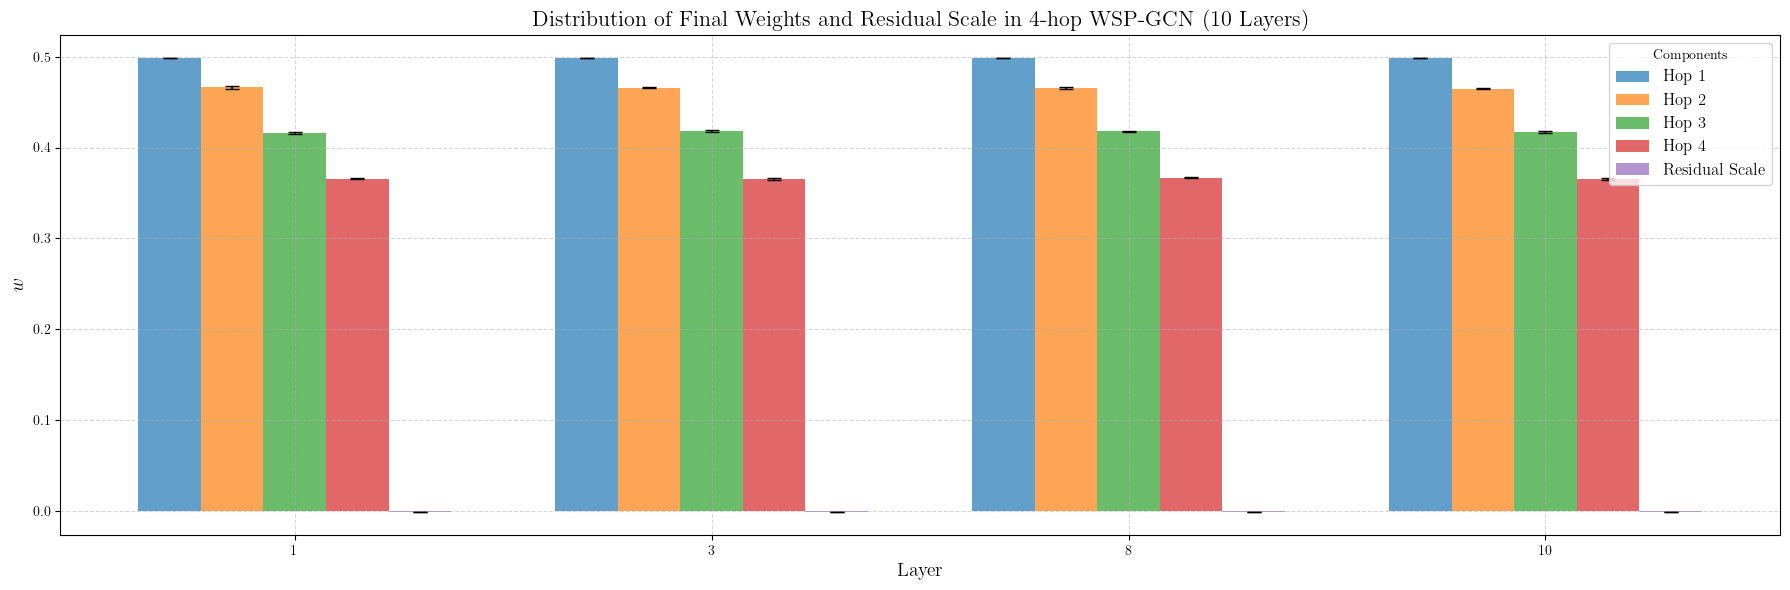

In [30]:

# Compute mean and std for 4-hop raw_weights
mean_4hop_raw = {layer: {hop: np.mean(weights_4hop_raw[layer][hop]) if weights_4hop_raw[layer][hop] else 0
                         for hop in range(1,5)} for layer in selected_layers}
std_4hop_raw = {layer: {hop: np.std(weights_4hop_raw[layer][hop]) if weights_4hop_raw[layer][hop] else 0
                        for hop in range(1,5)} for layer in selected_layers}

# Compute mean and std for residual_scale for 4-hop
mean_4hop_residual = {layer: np.mean(weights_4hop_residual[layer]) if weights_4hop_residual[layer] else 0
                      for layer in selected_layers}
std_4hop_residual = {layer: np.std(weights_4hop_residual[layer]) if weights_4hop_residual[layer] else 0
                     for layer in selected_layers}

# Define colors for hops and residual_scale
hop_colors = {
    1: '#1f77b4',        # Blue
    2: '#ff7f0e',        # Orange
    3: '#2ca02c',        # Green
    4: '#d62728',        # Red
    'residual_scale': '#9467bd'  # Purple
}

# Create the figure and single subplot for 4-hop
fig, ax = plt.subplots(figsize=(18, 6))

# Plot raw_weights for hops 1 to 4
bar_width = 0.15
index = np.arange(len(selected_layers))
offset = 0

for hop in range(1,5):
    means = [mean_4hop_raw[layer][hop] for layer in selected_layers]
    stds = [std_4hop_raw[layer][hop] for layer in selected_layers]
    ax.bar(index + (hop -1)*bar_width, means, bar_width, yerr=stds,
           color=hop_colors[hop], alpha=0.7, capsize=5, label=f"Hop {hop}")

# Plot residual_scale
means_residual = [mean_4hop_residual[layer] for layer in selected_layers]
stds_residual = [std_4hop_residual[layer] for layer in selected_layers]
ax.bar(index + (4)*bar_width, means_residual, bar_width, yerr=stds_residual,
       color=hop_colors['residual_scale'], alpha=0.7, capsize=5, label="Residual Scale")

# Set titles and labels
ax.set_title("Distribution of Final Weights and Residual Scale in 4-hop WSP-GCN (10 Layers)", fontsize=16)
ax.set_xlabel("Layer", fontsize=14)
ax.set_ylabel("$w$", fontsize=14)
ax.set_xticks(index + (4)*bar_width / 2)
ax.set_xticklabels(selected_layers)
ax.legend(title="Components", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig("final_weights_distribution_4hop_with_residual_scale.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Visualization #6: Weights over epochs

In [12]:
# Define the specific model and configuration to visualize
model_name = "WSP_GCN_2hop_residual_learnable"
n_layers_target = "10"  # Layer count as string since JSON keys are strings
n_hops = 2
selected_layers = [1, 3, 6, 10]  # Layers to plot

# Initialize a dictionary to store weights
# Structure: { hop: { layer: { run: [w_i over epochs] } } }
weights = {hop: {layer: {} for layer in selected_layers} for hop in range(1, n_hops+1)}
residual_scales = {layer: {} for layer in selected_layers}  # Structure: { layer: { run: [residual_scale over epochs] } }

# Access the runs for the specified model and layer count
runs_dict = results.get(model_name, {}).get(str(n_layers_target), {})
if not runs_dict:
    print(f"No runs found for {model_name} with {n_layers_target} layers.")
else:
    for run_num, run_data in runs_dict.items():
        weights_over_epochs = run_data.get("weights_over_epochs", {})
        if not weights_over_epochs:
            print(f"No weights_over_epochs found for {model_name}, layers {n_layers_target}, run {run_num}.")
            continue
        # Sort epochs in ascending order
        sorted_epochs = sorted(weights_over_epochs.keys(), key=lambda x: int(x))
        for epoch in sorted_epochs:
            layer_weights = weights_over_epochs[epoch]
            for layer_idx_str, layer_weights_dict in layer_weights.items():
                layer_idx = int(layer_idx_str) + 1  # Convert to 1-based index
                if layer_idx not in selected_layers:
                    continue
                # Extract raw_weights and residual_scale
                raw_weights = layer_weights_dict.get("raw_weights", [])
                residual_scale = layer_weights_dict.get("residual_scale", None)

                for hop in range(1, n_hops+1):
                    try:
                        w_i = float(raw_weights[hop-1])
                        sigmoid_w = torch.sigmoid(torch.tensor(w_i)).item()
                    except (IndexError, ValueError, TypeError):
                        print(f"Invalid raw_weight at Model: {model_name}, Layer: {layer_idx}, Hop: {hop}, Run: {run_num}, Epoch: {epoch}")
                        continue
                    # Initialize run list if not present
                    if run_num not in weights[hop][layer_idx]:
                        weights[hop][layer_idx][run_num] = []
                    weights[hop][layer_idx][run_num].append(sigmoid_w)

                if residual_scale is not None:
                    try:
                        residual_scale_val = float(residual_scale)
                    except (ValueError, TypeError):
                        print(f"Invalid residual_scale at Model: {model_name}, Layer: {layer_idx}, Run: {run_num}, Epoch: {epoch}")
                        continue
                    # Initialize run list if not present
                    if run_num not in residual_scales[layer_idx]:
                        residual_scales[layer_idx][run_num] = []
                    residual_scales[layer_idx][run_num].append(residual_scale_val)

# Compute statistics: mean, min, max for each hop and layer over epochs
# Structure for raw weights: { hop: { layer: { 'mean': [...], 'min': [...], 'max': [...] } } }
weight_stats = {hop: {layer: {'mean': [], 'min': [], 'max': []} for layer in selected_layers} for hop in range(1, n_hops+1)}
# Structure for residual scales: { layer: { 'mean': [...], 'min': [...], 'max': [...] } }
residual_stats = {layer: {'mean': [], 'min': [], 'max': []} for layer in selected_layers}

# Compute statistics for raw weights
for hop in range(1, n_hops+1):
    for layer in selected_layers:
        runs = weights[hop][layer]  # { run_num: [w_i over epochs] }
        if not runs:
            print(f"No raw_weights found for Hop: {hop}, Layer: {layer}")
            continue
        # Convert runs to a NumPy array for easier computation
        # Shape: [num_runs, num_epochs]
        runs_array = np.array(list(runs.values()))
        num_epochs = runs_array.shape[1]
        for epoch_idx in range(num_epochs):
            epoch_weights = runs_array[:, epoch_idx]
            mean_w = np.mean(epoch_weights)
            min_w = np.min(epoch_weights)
            max_w = np.max(epoch_weights)
            weight_stats[hop][layer]['mean'].append(mean_w)
            weight_stats[hop][layer]['min'].append(min_w)
            weight_stats[hop][layer]['max'].append(max_w)

# Compute statistics for residual scales
for layer in selected_layers:
    runs = residual_scales[layer]  # { run_num: [residual_scale over epochs] }
    if not runs:
        print(f"No residual_scales found for Layer: {layer}")
        continue
    # Convert runs to a NumPy array for easier computation
    # Shape: [num_runs, num_epochs]
    runs_array = np.array(list(runs.values()))
    num_epochs = runs_array.shape[1]
    for epoch_idx in range(num_epochs):
        epoch_scales = runs_array[:, epoch_idx]
        mean_scale = np.mean(epoch_scales)
        min_scale = np.min(epoch_scales)
        max_scale = np.max(epoch_scales)
        residual_stats[layer]['mean'].append(mean_scale)
        residual_stats[layer]['min'].append(min_scale)
        residual_stats[layer]['max'].append(max_scale)

print("Weight Statistics:", weight_stats)
print("Residual Scale Statistics:", residual_stats)

Weight Statistics: {1: {1: {'mean': [0.42673925310373306, 0.42796221375465393, 0.42918504029512405, 0.430407352745533, 0.4316287115216255, 0.4328486695885658, 0.4340668097138405, 0.4352826401591301, 0.43649572879076004, 0.4377056285738945, 0.4389118254184723, 0.4401138946413994, 0.4413113668560982, 0.44250375777482986, 0.44369062781333923, 0.44487153738737106, 0.446045957505703, 0.44721346348524094, 0.4483736678957939, 0.44952603429555893, 0.45067019015550613, 0.4518056735396385, 0.45293206721544266, 0.4540489614009857, 0.45515596121549606, 0.4562526270747185, 0.4573386460542679, 0.45841358602046967, 0.45947712659835815, 0.4605288803577423, 0.46156854182481766, 0.46259577572345734, 0.4636102616786957, 0.4646116942167282, 0.46559981256723404, 0.4665743410587311, 0.46753501892089844, 0.4684815853834152, 0.4694138318300247, 0.4703315198421478, 0.4712344780564308, 0.4721224904060364, 0.47299540787935257, 0.47385308146476746, 0.4746953547000885, 0.47552208602428436, 0.4763331785798073, 0.47

<ipython-input-23-20a811c159d4>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


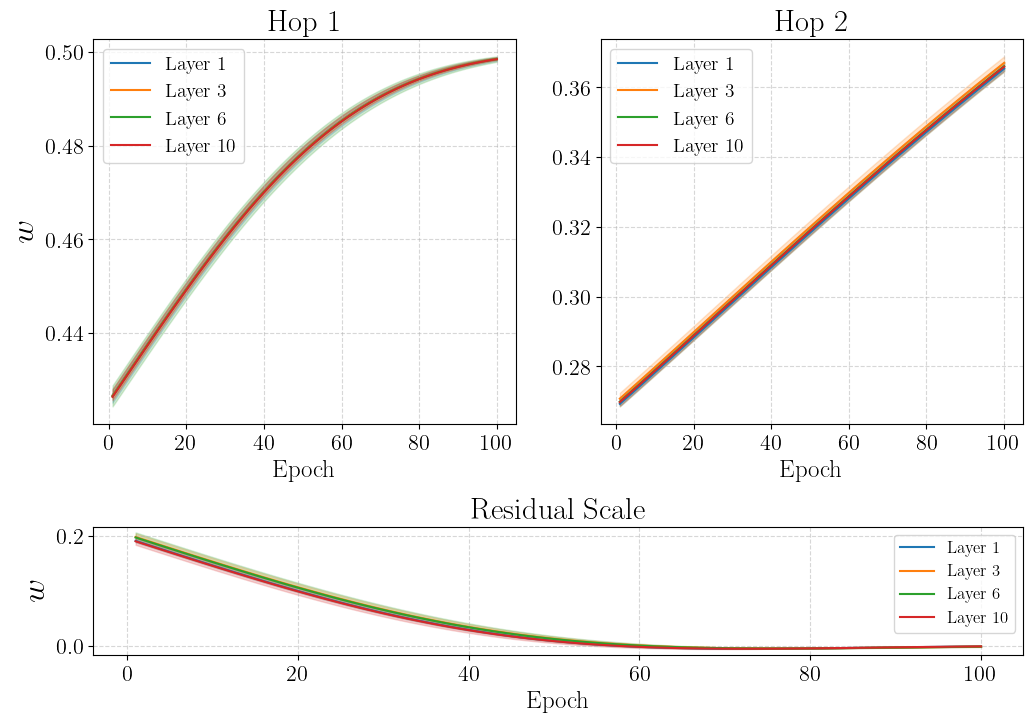

In [23]:
# Define distinct colors for each layer
layer_colors = {
    1: '#1f77b4',   # Blue
    3: '#ff7f0e',   # Orange
    6: '#2ca02c',   # Green
    10: '#d62728',  # Red
}

# Create the figure with subplots
# First row: Raw Weights for each hop
# Second row: Residual Scale
fig = plt.figure(figsize=(12, 8))
import matplotlib.gridspec as gridspec

# Define GridSpec with 2 rows: first for raw weights, second for residual scale
gs = gridspec.GridSpec(2, n_hops, height_ratios=[3, 1], hspace=0.4)

# Plot raw_weights for each hop
for hop in range(1, n_hops+1):
    ax = fig.add_subplot(gs[0, hop-1])
    for layer in selected_layers:
        stats = weight_stats[hop][layer]
        if not stats['mean']:
            continue
        epochs = np.arange(1, len(stats['mean']) +1)
        mean_w = stats['mean']
        min_w = stats['min']
        max_w = stats['max']
        color = layer_colors.get(layer, '#000000')  # Default to black if layer not found
        ax.plot(epochs, mean_w, label=f"Layer {layer}", color=color)
        ax.fill_between(epochs, min_w, max_w, alpha=0.2, color=color)
    ax.set_title(f"Hop {hop}", fontsize=22)
    ax.set_xlabel("Epoch", fontsize=18)
    if hop ==1:
        ax.set_ylabel("$w$", fontsize=24)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

# Plot residual_scale in the second row, spanning all hops
ax_residual = fig.add_subplot(gs[1, :])
for layer in selected_layers:
    stats = residual_stats[layer]
    if not stats['mean']:
        continue
    epochs = np.arange(1, len(stats['mean']) +1)
    mean_scale = stats['mean']
    min_scale = stats['min']
    max_scale = stats['max']
    color = layer_colors.get(layer, '#000000')  # Default to black if layer not found
    ax_residual.plot(epochs, mean_scale, label=f"Layer {layer}", color=color)
    ax_residual.fill_between(epochs, min_scale, max_scale, alpha=0.2, color=color)

ax_residual.set_title("Residual Scale", fontsize=22)
ax_residual.set_xlabel("Epoch", fontsize=18)
ax_residual.set_ylabel("$w$", fontsize=24)
ax_residual.legend(fontsize=12)
ax_residual.grid(True, linestyle='--', alpha=0.5)
ax_residual.tick_params(axis='both', labelsize=16)

# Add a super title
# plt.suptitle(f"Evolution of Weights and Residual Scale over Epochs for {model_name} with {n_layers_target} Layers", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("weights_and_residual_scale_evolution.pdf", format="pdf", bbox_inches="tight")
plt.show()